# Sparkify Customer Churn Prediction

The following project is part of my Udacity Data Science Nano Degree. The project and the dataset was provided by Udacity. <br>
This project is about an imaginary platform provider for music streaming (similarly to Spotify or Pandora) called <b>Sparkify</b>. We analyze for Sparkify the customer habits in order to be able to predict, if customers are about to churn from the platform. By analyzing, we want to identify measurements with predictive power for customer churn and create a model leveraging these measurements for prediction. 

Within this project, it will be more important to avoid False Negatives, as this would mean a churning customer had not been identified upfront. For this reason the mainly focussed model measurement will be the Recall to evaluate the model, as the Recall (True Positives / all Positives) punishes False Negatives. The target of this project is a model with a <b>Recall Score greater than 80%</b>.

## Section 1: Business Understanding

Sparkify is a music streaming platform. This service can be leveraged on a free or a paid tier. When using a free tier this service includes advertising. 
Customers can register to the service and use the free tier. In order to use the paid tier w/o advertising the customer needs to upgrade their account by visiting the "Upgrade"-page and submitting their upgrade. Paid customers can also downgrade their service to the free tier by visiting the "Downgrade" page and submitting their downgrade. 
Both, paid customers and free customers can cancel their registration by visiting the "Cancel" page and confirm cancellation. 
The following work will treat customer churn as customers leaving (cancelling) the service at all. 

A Customer can visit any of the following pages:
* Cancel
* Submit Downgrade
* Thumbs Down
* Home
* Downgrade
* Roll Advert
* Logout
* Save Settings
* Cancellation Confirmation
* About
* Submit Registration
* Settings
* Login
* Register
* Add to Playlist
* Add Friend
* NextSong
* Thumbs Up
* Help
* Upgrade
* Error
* Submit Upgrade

### Installing and importing required libraries to EMR Cluster

In [1]:
sc.list_packages()

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
2,application_1623520201468_0003,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.8.1
boto                       2.49.0
jmespath                   0.9.4
lxml                       4.4.2
mysqlclient                1.4.6
nltk                       3.4.5
nose                       1.3.4
numpy                      1.14.5
pip                        21.1.2
py-dateutil                2.2
python36-sagemaker-pyspark 1.2.6
pytz                       2019.3
PyYAML                     3.11
setuptools                 57.0.0
six                        1.13.0
soupsieve                  1.9.5
wheel                      0.36.2
windmill                   1.6

In [2]:
sc.install_pypi_package("pandas==0.25.1") #Install pandas version 0.25.1 on EMR
sc.install_pypi_package("matplotlib==3.1.1") #Install matplotlib version 3.1.1 on EMR
sc.install_pypi_package("seaborn==0.11.1") #Install seaborn version 0.11.1 on EMR


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Using cached pandas-0.25.1-cp36-cp36m-manylinux1_x86_64.whl (10.5 MB)
  Using cached python_dateutil-2.8.1-py2.py3-none-any.whl (227 kB)

  Using cached matplotlib-3.1.1-cp36-cp36m-manylinux1_x86_64.whl (13.1 MB)
  Using cached pyparsing-2.4.7-py2.py3-none-any.whl (67 kB)
  Using cached kiwisolver-1.3.1-cp36-cp36m-manylinux1_x86_64.whl (1.1 MB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)

  Using cached seaborn-0.11.1-py3-none-any.whl (285 kB)
  Using cached scipy-1.5.4-cp36-cp36m-manylinux1_x86_64.whl (25.9 MB)
  Using cached numpy-1.19.5-cp36-cp36m-manylinux2010_x86_64.whl (14.8 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.14.5
    Not uninstalling numpy at /usr/local/lib64/python3.6/site-packages, outside environment /tmp/1623523312038-0
    Can't uninstall 'numpy'. No files were found to uninstall.



ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source 

In [3]:
sc.list_packages()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Package                    Version
-------------------------- -------
beautifulsoup4             4.8.1
boto                       2.49.0
cycler                     0.10.0
jmespath                   0.9.4
kiwisolver                 1.3.1
lxml                       4.4.2
matplotlib                 3.1.1
mysqlclient                1.4.6
nltk                       3.4.5
nose                       1.3.4
numpy                      1.19.5
pandas                     0.25.1
pip                        21.1.2
py-dateutil                2.2
pyparsing                  2.4.7
python-dateutil            2.8.1
python36-sagemaker-pyspark 1.2.6
pytz                       2019.3
PyYAML                     3.11
scipy                      1.5.4
seaborn                    0.11.1
setuptools                 57.0.0
six                        1.13.0
soupsieve                  1.9.5
wheel                      0.36.2
windmill                   1.6

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import numpy as np

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.types import IntegerType

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


pd.set_option('display.max_columns', 50)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [5]:
# Create spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Section 2: Data Understanding

In [6]:
# Read in full sparkify dataset
event_data = "s3n://udacity-dsnd/sparkify/sparkify_event_data.json"
event_data_mini = "s3n://udacity-dsnd/sparkify/mini_sparkify_event_data.json"
df = spark.read.json(event_data_mini)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)

In [8]:
# df shape
print((df.count(), len(df.columns)))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

(286500, 18)

In [9]:
df.show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

In [10]:
# describing each numeric-like column

for column in df.dtypes:
    if column[1] != 'string':
        print(df.describe(column[0]).show())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+------------------+
|summary|     itemInSession|
+-------+------------------+
|  count|            286500|
|   mean|114.41421291448516|
| stddev|129.76726201141108|
|    min|                 0|
|    max|              1321|
+-------+------------------+

None
+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            228108|
|   mean|249.11718197783375|
| stddev| 99.23517921058327|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+

None
+-------+--------------------+
|summary|        registration|
+-------+--------------------+
|  count|              278154|
|   mean|1.535358834085557E12|
| stddev| 3.291321616327432E9|
|    min|       1521380675000|
|    max|       1543247354000|
+-------+--------------------+

None
+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630799|
|    min|    

In [11]:
# count values for each column

for column in df.dtypes:
    print(df.select(F.col(column[0])).groupBy(F.col(column[0])).count().orderBy(F.col('count').desc()).show(10))

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|              artist|count|
+--------------------+-----+
|                null|58392|
|       Kings Of Leon| 1841|
|            Coldplay| 1813|
|Florence + The Ma...| 1236|
|       Dwight Yoakam| 1135|
|            BjÃÂ¶rk| 1133|
|      The Black Keys| 1125|
|                Muse| 1090|
|       Justin Bieber| 1044|
|        Jack Johnson| 1007|
+--------------------+-----+
only showing top 10 rows

None
+----------+------+
|      auth| count|
+----------+------+
| Logged In|278102|
|Logged Out|  8249|
|     Guest|    97|
| Cancelled|    52|
+----------+------+

None
+---------+-----+
|firstName|count|
+---------+-----+
|   Payton| 9632|
|     null| 8346|
|    Riley| 7970|
|   Lucero| 6880|
|   Emilia| 5732|
|     Emma| 5478|
|   Joseph| 5209|
|    Colin| 4989|
|   Nicole| 4825|
|   Joshua| 4654|
+---------+-----+
only showing top 10 rows

None
+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
|  null|  8346|
+------+------+

N

In [12]:
# checking for null or null-like ('') values in columns

for column in df.dtypes:
    print(df.filter((F.col(column[0]).isNull()==True) | (F.col(column[0])=='')).select(F.col(column[0])).groupBy(F.col(column[0])).count().show())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+-----+
|artist|count|
+------+-----+
|  null|58392|
+------+-----+

None
+----+-----+
|auth|count|
+----+-----+
+----+-----+

None
+---------+-----+
|firstName|count|
+---------+-----+
|     null| 8346|
+---------+-----+

None
+------+-----+
|gender|count|
+------+-----+
|  null| 8346|
+------+-----+

None
+-------------+-----+
|itemInSession|count|
+-------------+-----+
+-------------+-----+

None
+--------+-----+
|lastName|count|
+--------+-----+
|    null| 8346|
+--------+-----+

None
+------+-----+
|length|count|
+------+-----+
|  null|58392|
+------+-----+

None
+-----+-----+
|level|count|
+-----+-----+
+-----+-----+

None
+--------+-----+
|location|count|
+--------+-----+
|    null| 8346|
+--------+-----+

None
+------+-----+
|method|count|
+------+-----+
+------+-----+

None
+----+-----+
|page|count|
+----+-----+
+----+-----+

None
+------------+-----+
|registration|count|
+------------+-----+
|        null| 8346|
+------------+-----+

None
+---------+-----+
|sessionId|c

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

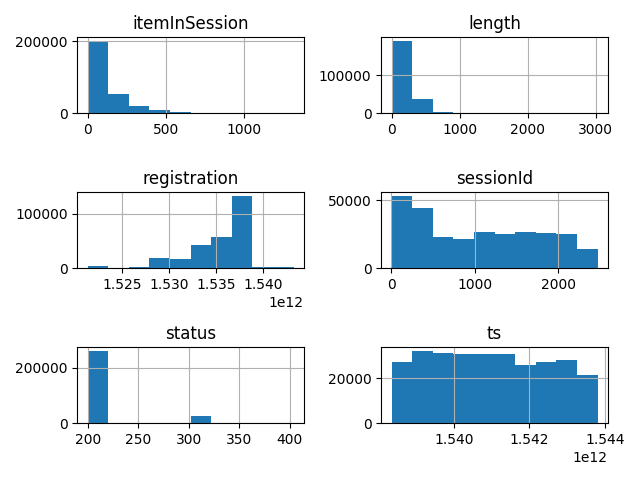

In [13]:
# value distribution of numeric values

df.toPandas().hist()
plt.tight_layout()
%matplot plt

In [14]:
# all possible pages visited 

df.select(F.col('Page')).drop_duplicates().show(50, False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------------+
|Page                     |
+-------------------------+
|Cancel                   |
|Submit Downgrade         |
|Thumbs Down              |
|Home                     |
|Downgrade                |
|Roll Advert              |
|Logout                   |
|Save Settings            |
|Cancellation Confirmation|
|About                    |
|Submit Registration      |
|Settings                 |
|Login                    |
|Register                 |
|Add to Playlist          |
|Add Friend               |
|NextSong                 |
|Thumbs Up                |
|Help                     |
|Upgrade                  |
|Error                    |
|Submit Upgrade           |
+-------------------------+

In [15]:
# what is gender null?
df.filter(F.col('Gender').isNull()==True).select('userId','firstName','lastName').drop_duplicates().show(25)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+---------+--------+
|userId|firstName|lastName|
+------+---------+--------+
|      |     null|    null|
+------+---------+--------+

## Section 3: Data Preparation

In order to tackle the problem, an user_df will be created with 1 row per user. The next steps will include feature engeneering to calculate relevant measurements with predictive power for customer churn. 

* <b>isGenderFemale</b>: 
Indicator, if the userId is female or not. There might be a correlation between the gender and the sensitivity for churning
* <b>label (churned user)</b>: 
Indicator, if the user churned or not. This is the label which needs to be predicted by the model. 
* <b>downgraded</b>: 
Indicator, if the user ever downgraded from paid to free tier. There might be a different behavior of a user, who ever downgraded vs. who did not in terms of churning. A downgraded customer might be already dissatisfied. 
* <b>isPaidCustomer</b>: 
Indicator, if the users latest level is the paid tier or not. Paid customers might have a higher restraint to churn. 
* <b>membershipDurationDays</b>: 
Number of days from first interaction with Sparkify to latest interaction with Sparkify. The membership duration might indicate the satisfaction towards the service. 
* <b>numberOfSongs, numberOfSongsPerDay</b>: 
Number of songs totally consumed by the user, and per day of membership in average. The Number of songs per day might indicate the level of usage of the service and indicate the level of satisfaction towards the service. 
* <b>thumbsDown, thumbsUp, relThumbsDown, relThumbsUp</b>: 
The rating behavior of the user. Total number of Thumb Up and Down interactions. Each rating interaction is also calculated per song consumed to achieve the number of Thumbs Up and Down per song listened to. This might indicate the satisfaction of the user towards Sparkify
* <b>songsSkipped</b>: 
Number of songs skipped before they ended. This might indicate if an user receives bad song recommendation what might reduce the level of satisfaction. 
* <b>numberOfErrors, numberOfInteractions, relNumberOfErrors</b>: 
The number of Errors received from the service and versus all interactions with the system might indicate the system performance for the user. A bad system performance might end up in a higher level of dissatisfaction. 
* <b>downgradeAttempts</b>: 
How often did a user visit the "Downgrade"-page. An user might not downgrade direcly, but visit the downgrade page, rethink about it and decide not to submit the downgrade. But a user, trying to downgrade but not submitting the downgrade might already indicate a level of dissatisfaction towards the service.
* <b>numberOfSongsPerSession</b>: 
When the service is used, how long does the user use the service. Longer session utilization might indicate a higher level of satisfaction. 
* <b>addedFriends</b>: 
The total number of friends added to the platform per user. Hypothis: The higher the social interaction with the system the higher might be the bonding to the system and the higher the restraints to churn. 
* <b>skew</b>: 
The skew of the distribution of songs per day per user (from first interaction to last). A right skewed distribution of songs might indicate a decrease of satisfaction of relevance of the service for the user. 

In [16]:
# filtering out all rows with no user or session associated

df = df.filter(F.col('userId')!='')\
       .filter(F.col('userId').isNull()==False)\
       .filter(F.col('sessionId').isNull()==False)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [17]:
# creation of a dimensional user df

user_cols = ['userId', 'gender']

user_df = df.select(user_cols).drop_duplicates().cache()

user_df.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------+------+
|userId|gender|
+------+------+
|    44|     F|
|    46|     F|
|    41|     F|
|    72|     F|
|300023|     F|
+------+------+
only showing top 5 rows

In [18]:
# qc for duplicated userIds

if user_df.select('userId').groupBy(F.col('userId')).count().orderBy(F.col('count').desc()).filter(F.col('count')>1).count() > 0:
    print('user_df has duplicated userId')
else:
    print('user_df at correct level of detail')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

user_df at correct level of detail

In [19]:
#There is a gender null in the origin dataset but the gender null is associated to userId null only. userId null had been filtered out the dataset. 
def is_gener_female(user_df):
    '''
    INPUT:
    user_df - spark df with one row per user_id
    
    OUTPUT
    user_df - spark df with added column 'isGenderFemale'
    
    This function adds an indicator for customers churned from service to user_df.

    '''

    user_df = user_df.withColumn('isGenderFemale', F.when(F.col('gender')=='F', F.lit(1)).otherwise(F.lit(0)))
    
    return user_df

user_df = is_gener_female(user_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [20]:
# adding churned users to user_df

def churned_users(df, user_df):
    '''
    INPUT:
    df - log df structure
    user_df - spark df with one row per user_id
    
    OUTPUT
    user_df - spark df with added column 'churned'
    
    This function adds an indicator for customers churned from service to user_df.

    '''
    
    churned_users = df.filter((F.col('page') == 'Cancellation Confirmation')).select('userId').drop_duplicates()
    churned_users = churned_users.withColumn('label', F.lit(1))

    user_df = user_df.join(churned_users, 'userId', how='left').fillna(value=0, subset=['label'])
    
    return user_df

user_df = churned_users(df, user_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [21]:
# adding indicator for users who downgraded from paid to free for user_df

def downgraded(df, user_df):
    '''
    INPUT:
    df - log df structure
    user_df - spark df with one row per user_id
    
    OUTPUT
    user_df - spark df with added column 'downgraded'
    
    This function adds an indicator for customers downgraded from paid to free per userId to user_df.

    '''

    downgraded_users = df.filter((F.col('page') == 'Submit Downgrade')).select('userId').drop_duplicates()
    downgraded_users = downgraded_users.withColumn('downgraded', F.lit(1))

    user_df = user_df.join(downgraded_users, 'userId', how='left').fillna(value=0, subset=['downgraded'])
    
    return user_df

user_df = downgraded(df, user_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [22]:
def is_paid_customer(df, user_df):
    '''
    INPUT:
    df - log df structure
    user_df - spark df with one row per user_id
    
    OUTPUT
    user_df - spark df with added column 'isPaidCustomer'
    
    This function adds an indicator per user if the latest status of the customer is paid level to user_df.

    '''

    latest_tier = df.withColumn('rn_desc', F.row_number().over(Window.partitionBy(F.col('userId')).orderBy(F.col('ts').desc())))\
                    .filter(F.col('rn_desc')==1)\
                    .withColumn('isPaidCustomer', F.when(F.col('level')=='paid', F.lit(1)).otherwise(F.lit(0)))\
                    .select('userId','isPaidCustomer')

    user_df = user_df.join(latest_tier, 'userId', how='left').fillna(value=0, subset=['isPaidCustomer'])
    
    return user_df

user_df = is_paid_customer(df, user_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [23]:
# adding number of membership days per user to user_df
def membership_duration(df, user_df):
    '''
    INPUT:
    df - log df structure
    user_df - spark df with one row per user_id
    
    OUTPUT
    user_df - spark df with added column 'membershipDurationDays'
    
    This function calculates the membership duration in days per userId and adds this to user_df. 

    '''

    df_member = df.select('userId','ts').groupBy('userId').agg(F.min('ts'), F.max('ts'))
    df_member = df_member.withColumn('membershipDurationDays', (F.col('max(ts)') - F.col('min(ts)'))/1000/60/60/24)

    user_df = user_df.join(df_member, 'userId', how='left').fillna(value=0, subset=['membershipDurationDays'])
    
    return user_df

user_df = membership_duration(df, user_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [24]:
def number_of_songs(df, user_df):
    '''
    INPUT:
    df - log df structure
    user_df - spark df with one row per user_id
    
    OUTPUT
    user_df - spark df with added columns 'numberOfSongs', 'numberOfSongsPerDay'
    
    This function calculates the total number of songs consumed per userId and adds this column to the user_df. 
    Additionally this function calculates based on the column 'membershipDurationDays' present in user_df the number of Songs per day per userId.

    '''
    
    df_listen = df.filter(F.col('song').isNull()==False)
    df_listen = df_listen.select('userId','song').groupBy(F.col('userId')).count().withColumnRenamed('count','numberOfSongs')

    user_df = user_df.join(df_listen, 'userId', how='left').fillna(value=0, subset=['numberOfSongs'])
    user_df = user_df.withColumn('numberOfSongsPerDay', F.col('numberOfSongs')/F.col('membershipDurationDays'))
    
    return user_df
    
user_df = number_of_songs(df, user_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [25]:
def rating(df, user_df):
    '''
    INPUT:
    df - log df structure
    user_df - spark df with one row per user_id
    
    OUTPUT
    user_df - spark df with added columns 'thumbsDown', 'thumbsUp', 'relThumbsDown', 'relThumbsUp'
    
    This function calculates the total number of Thumbs Down and total number of Thumbs Up interactions per userId and adds those to the user_df. 
    Additionally this function calculates based on the column 'numberOfSongs' present in user_df the number relative number of Thumbs Up and Thumbs Down
    interaction per song per userId.
    '''
    
    df_rating = df.filter(F.col('page').isin(['Thumbs Down','Thumbs Up'])==True).select('userId','page').groupBy(F.col('userId')).pivot('page').count()
    df_rating = df_rating.withColumnRenamed('Thumbs Down','thumbsDown').withColumnRenamed('Thumbs Up','thumbsUp')

    user_df = user_df.join(df_rating, 'userId', how='left').fillna(value=0, subset=['thumbsDown','thumbsUp'])
    
    user_df = user_df.withColumn('relThumbsDown', F.col('thumbsDown')/F.col('numberOfSongs'))\
                     .withColumn('relThumbsUp', F.col('thumbsUp')/F.col('numberOfSongs'))
    
    return user_df

user_df = rating(df, user_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
def songs_skipped(df, user_df):
    '''
    INPUT:
    df - log df structure
    user_df - spark df with one row per user_id
    
    OUTPUT
    user_df - spark df with added columns 'songsSkipped', 'relSongsskipped'
    
    This function calculates the total number of songs skipped per userId and adds this column to the user_df. The total number of songs skipped
    is defined as interaction when the next song is played at least 5 seconds before the former song ended. 
    Additionally this function calculates based on the column 'numberOfSongs' present in user_df the relative number of Songs skipped per song per userId.
    '''

    # filter df for all song listening activities
    df_skipped = df.filter(F.col('song').isNull()==False).orderBy(F.col('ts'))

    # 1. getting the sessionId of the next activity per user
    # 2. if the next sessionId of the user activity equals to the former, getting the ts of the next sessionId
    # 3. calculating the difference of the ts of the former and the next activity
    # 4. calculating the difference of the duration between the two consecutive activities and the length of the song. if this difference is greater than 5 seconds this song is defined as skipped song. 
    df_skipped = df_skipped.withColumn('sessionIdNextSong', F.lead(F.col('sessionId'), 1).over(Window.orderBy('userId','ts')))\
                           .withColumn('tsAfterSong', F.when(F.col('sessionIdNextSong')==F.col('sessionId'), F.lead(F.col('ts'), 1).over(Window.orderBy('userId','ts')))\
                                                       .otherwise(F.lit(None)))\
                           .withColumn('durationOfSongListened', F.col('tsAfterSong') - F.col('ts')) \
                           .withColumn('songSkipped', F.when(F.abs(F.col('durationOfSongListened')/1000 - F.col('length')) > 10, 1).otherwise(0))

    #calculating the number of skipped songs per userId
    df_skipped = df_skipped.filter(F.col('songSkipped')==1).select('userId').groupBy(F.col('userId')).count()
    df_skipped = df_skipped.withColumnRenamed('count','songsSkipped')

    #adding the number of skipped songs to the user_df
    user_df = user_df.join(df_skipped, 'userId', how='left').fillna(value=0, subset=['songsSkipped'])
    
    #calculating the relative number of skipped songs
    user_df = user_df.withColumn('relSongsskipped', F.col('songsSkipped')/F.col('numberOfSongs'))
    
    return user_df

user_df = songs_skipped(df, user_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [27]:
def errors(df, user_df):
    '''
    INPUT:
    df - log df structure
    user_df - spark df with one row per user_id
    
    OUTPUT
    user_df - spark df with added columns 'numberOfErrors', 'relNumberOfErrors'
    
    This function calculates the total number of errors occured per userId and the total number of activities per userId 
    and adds these column to the user_df. 
    Additionally this function calculates the relative number of errors per activity per userId.
    '''
    # number of errors occured per user added to user_df
    
    df_err = df.filter(F.col('status')==404).select('userId').groupBy('userId').count()
    df_err = df_err.withColumnRenamed('count', 'numberOfErrors')

    user_df = user_df.join(df_err, 'userId', how='left').fillna(value=0, subset=['numberOfErrors'])
    
    
    # in order to express the number of errors relatively the total number of interactions per user is added to user_df
    # based on number of errors and total number of interactions the relative number of errors is calculated

    df_interact = df.select('userId').groupBy('userId').count()
    df_interact = df_interact.withColumnRenamed('count','numberOfInteractions')
    user_df = user_df.join(df_interact, 'userId', how='left')

    user_df = user_df.withColumn('relNumberOfErrors', F.col('numberOfErrors')/F.col('numberOfInteractions'))
    
    return user_df

user_df = errors(df, user_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [28]:
def downgrade_attempts(df, user_df):
    '''
    INPUT:
    df - log df structure
    user_df - spark df with one row per user_id
    
    OUTPUT
    user_df - spark df with added columns 'churnAttempts'
    
    This function calculates the total number of 'Cancel' (or 'Downgrade' if paid = True) activities per userId and adds this column to the user_df. 
    '''
    # the number of downgrade attempts  added to user_df

    downgrade_indicator=['Downgrade']
    
    df_churn = df.filter(F.col('page').isin(downgrade_indicator)).select('userId').groupBy('userId').count()
    df_churn = df_churn.withColumnRenamed('count', 'downgradeAttempts')

    user_df = user_df.join(df_churn, 'userId', how='left').fillna(value=0, subset=['downgradeAttempts'])
    
    return user_df

user_df = downgrade_attempts(df, user_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
def mean_songs_per_session(df, user_df):
    '''
    INPUT:
    df - log df structure
    user_df - spark df with one row per user_id
    
    OUTPUT
    user_df - spark df with added columns 'numberOfSongsPerSession'
    
    This function calculates the mean number of songs per sessionId per userId and adds this column to the user_df. 
    '''
    # the number of songs per session in averade added to user_df
    
    df_mean = df.filter(F.col('song').isNull()==False).groupBy('userId', 'sessionId').count()
    df_mean = df_mean.select('userId','count').groupBy('userId').mean()
    df_mean = df_mean.withColumnRenamed('avg(count)', 'numberOfSongsPerSession')

    user_df = user_df.join(df_mean, 'userId', how='left').fillna(value=0, subset=['numberOfSongsPerSession'])
    
    return user_df

user_df = mean_songs_per_session(df, user_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [30]:
def added_friends(df, user_df):
    '''
    INPUT:
    df - log df structure
    user_df - spark df with one row per user_id
    
    OUTPUT
    user_df - spark df with added columns 'addedFriends'
    
    This function calculates the 'Add Friend' activities per userId and adds this column to the user_df. 
    '''
    
    df_friend = df.filter(F.col('page')=='Add Friend').groupBy('userId').count()
    df_friend = df_friend.withColumnRenamed('count', 'addedFriends')

    user_df = user_df.join(df_friend, 'userId', how='left').fillna(value=0, subset=['addedFriends'])
    
    return user_df

user_df = added_friends(df, user_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [31]:
def skew_songs_per_day(df, user_df):
    '''
    INPUT:
    df - log df structure
    user_df - spark df with one row per user_id
    
    OUTPUT
    user_df - spark df with added columns 'skew'
    
    This function calculates the the distribution of song listening activities per userId over time. Based on this distribution the skew of the 
    distribution is calculated and added to the user_df. 
    '''
    
    df_skew = df.filter(F.col('song').isNull()==False).withColumn('date', (F.col('ts')).cast('timestamp')).select('userId','ts')
    df_skew = df_skew.groupBy('userId').agg(F.skewness('ts')).withColumnRenamed('skewness(ts)', 'skew')

    user_df = user_df.join(df_skew, ['userId'], how='left').fillna(value=0, subset=['skew'])
    
    return user_df

user_df = skew_songs_per_day(df, user_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Dataset finalization

In [32]:
#due to sparks lazy evaluation, the user_df will be cached
user_df = user_df.persist()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [33]:
user_df.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- userId: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- isGenderFemale: integer (nullable = false)
 |-- label: integer (nullable = true)
 |-- downgraded: integer (nullable = true)
 |-- isPaidCustomer: integer (nullable = true)
 |-- min(ts): long (nullable = true)
 |-- max(ts): long (nullable = true)
 |-- membershipDurationDays: double (nullable = false)
 |-- numberOfSongs: long (nullable = true)
 |-- numberOfSongsPerDay: double (nullable = true)
 |-- thumbsDown: long (nullable = true)
 |-- thumbsUp: long (nullable = true)
 |-- relThumbsDown: double (nullable = true)
 |-- relThumbsUp: double (nullable = true)
 |-- songsSkipped: long (nullable = true)
 |-- relSongsskipped: double (nullable = true)
 |-- numberOfErrors: long (nullable = true)
 |-- numberOfInteractions: long (nullable = true)
 |-- relNumberOfErrors: double (nullable = true)
 |-- downgradeAttempts: long (nullable = true)
 |-- numberOfSongsPerSession: double (nullable = false)
 |-- addedFriends: 

In [34]:
# Number of null values in any column of the user_df

# Reference: https://stackoverflow.com/questions/44627386/how-to-find-count-of-null-and-nan-values-for-each-column-in-a-pyspark-dataframe
# Reference: https://stackoverflow.com/questions/31955309/add-column-sum-as-new-column-in-pyspark-dataframe/31955747

def numbers_of_null(user_df):
    '''
    INPUT:
    user_df - spark df with one row per user_id
    
    OUTPUT
    None    
    
    This function prints the number of null values in all columns of the given df
    '''

    number_of_nulls = user_df.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in user_df.columns])
    number_of_nulls = number_of_nulls.withColumn('total_number_of_nulls', sum(number_of_nulls[col] for col in number_of_nulls.columns))
    number_of_nulls.select('total_number_of_nulls').show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [35]:
numbers_of_null(user_df)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------+
|total_number_of_nulls|
+---------------------+
|                    0|
+---------------------+

## Section 4: Modeling 

For the modeling part, the user_df will be transformed that way, that only needed columns will be kept. 
The df will be split into training and test dataset with a train-test split of 80/20. 
The df will be vector assembled and scaled using the standard scaler. 

For the modeling part, a logistic regression and a gradient boost tree model will be trained and compared. The main measure to evaluate will be the recall, as already justified at the beginning of this notebook. 

In [36]:
def train_test_df_creation(user_df, chosen_cols, train_size=.8, seed=42):
    '''
    INPUT:
    user_df - spark df with one row per user_id
    chosen_cols - list of columns to be present in the output df
    train_size - float between 0 and 1 defining the split of the train df
    seed - random seed of the random split
    
    OUTPUT
    train_df - spark df split based on the train_size randomly based on the seed with only chosen_cols present
    test_df - spark df split based on the train_size randomly based on the seed with only chosen_cols present

    This function 
    1. selects only the chosen_cols and
    2. performs a random split based on train_size and seed
    '''
    
    user_df = user_df.select(chosen_cols)

    train_df, test_df = user_df.randomSplit([train_size, 1-train_size], seed=seed)

    train_df, test_df = train_df.cache(), test_df.cache()
    
    return train_df, test_df


VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [37]:
chosen_cols = ['userId','isGenderFemale','label','membershipDurationDays','numberOfSongs','numberOfSongsPerDay','downgradeAttempts',
               'relThumbsDown','relThumbsUp','relSongsSkipped','relNumberOfErrors','numberOfSongsPerSession',
               'numberOfSongsPerSession','addedFriends','skew', 'downgraded', 'isPaidCustomer']

train_df, test_df = train_test_df_creation(user_df, chosen_cols)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Model

In [38]:
def instantiate_assembler_scaler(inputCols):
    '''
    INPUT:
    inputCols - list of columns to take into account for ML model
    
    OUTPUT:
    None
    
    The VectorAssembler and the Standard Scaler will be instantiated.     
    '''

    assembler = VectorAssembler(inputCols=inputCols, outputCol='featureVec', handleInvalid='skip')
    scaler = StandardScaler(inputCol='featureVec', outputCol='featureVecScaled')
    
    return assembler, scaler

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [39]:
def calculate_lr_feature_importance(cv_model_lr, inputCols):
    '''
    INPUT:
    cv_model_lr - CrossValidator Object of a linear regression model
    inputCols - list of columns taken into account for model training
    
    OUTPUT:
    feature importance - pandas dataframe of feature importances
    
    this function extracts the feature importance of the best model of the CV object and returns these into a pandas dataframe
    '''
    
    shape0 = cv_model_lr.bestModel.stages[2].coefficientMatrix.values.shape[0]
    
    #retrieving lr coefficients (absolute) from cv_mode_lr
    coef = cv_model_lr.bestModel.stages[2].coefficientMatrix.values.reshape(1,shape0)

    #creation of pandas DF for feature importance
    feature_importance = pd.DataFrame(coef, columns=inputCols).melt()
    feature_importance['abs_value'] = feature_importance['value'].abs()
    feature_importance = feature_importance.sort_values('abs_value', ascending=False)
    
    return feature_importance[['variable', 'value']]

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [40]:
def do_logistic_regression(train_df, test_df, inputCols):
    '''
    INPUT:
    train_df - spark df with train dataset
    test_df - spark df with test dataset
    inputCols - list of columns to take into account for ML model
    
    OUTPUT:
    cv_model_lr - trained spark CrossValidator object
    
    This function trains and tests a logistic regression model, performs a grid search based on regParam, 
    prints the performance measures of the model and returns the CV object. 
    '''
    
    assembler, scaler = instantiate_assembler_scaler(inputCols)

    #instantiate logistic regression model
    model_lr = LogisticRegression(labelCol='label', featuresCol='featureVecScaled', maxIter=10)

    #instantiate evaluators
    accuracy_evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
    precision_evaluator = MulticlassClassificationEvaluator(metricName="weightedPrecision")
    recall_evaluator = MulticlassClassificationEvaluator(metricName="weightedRecall")
    f1_evaluator = MulticlassClassificationEvaluator(metricName="f1")

    #instantiate pipeline
    pipe_lr = Pipeline(stages=[assembler, scaler, model_lr])

    #define GridSearch parameters to optimize
    paramGrid = ParamGridBuilder() \
                .addGrid(model_lr.regParam, [0.1, 0.01]) \
                .build()

    #wrapping pipeline in CrossValidator to perform GridSearch optimization
    crossval = CrossValidator(estimator=pipe_lr,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(),
                              numFolds=3)

    #fitting model
    cv_model_lr = crossval.fit(train_df)

    #make predictions on test dataset
    results_lr = cv_model_lr.transform(test_df)
    feature_importance = calculate_lr_feature_importance(cv_model_lr, inputCols)

    #calculating performance measures
    accuracy = accuracy_evaluator.evaluate(results_lr)
    precision = precision_evaluator.evaluate(results_lr)
    recall = recall_evaluator.evaluate(results_lr)
    f1_score = f1_evaluator.evaluate(results_lr)

    #print performance measures
    print('LR:\tAccuracy {:.3f} \t|\t Precision {:.3f} \t|\t Recall {:.3f} \t|\t f1-score {:.3f}'.format(accuracy, precision, recall, f1_score))
    
    return cv_model_lr, feature_importance

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
def calculate_gbt_feature_importance(cv_model_gbt):
    '''
    INPUT:
    cv_model_lr - CrossValidator Object of a linear regression model
    
    OUTPUT:
    feature importance - pandas dataframe of feature importances
    
    this function extracts the feature importance of the best model of the CV object and returns these into a pandas dataframe
    '''
    
    va = cv_model_gbt.bestModel.stages[0]
    treeCV = cv_model_gbt.bestModel.stages[2]

    feature_importance = pd.DataFrame(list(zip(va.getInputCols(), treeCV.featureImportances)), columns=['variable','value']).sort_values('value', ascending=False)
        
    return feature_importance

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [42]:
def do_gbt(train_df, test_df, inputCols):
    '''
    INPUT:
    train_df - spark df with train dataset
    test_df - spark df with test dataset
    assembler - spark assembler object
    scaler - spark scaler object
    
    OUTPUT:
    cv_model_gbt - trained spark CrossValidator object
    
    This function trains and tests a Gradient Boost Tree model, performs a grid search based on maxDepth, 
    prints the performance measures of the model and returns the CV object. 
    '''
    
    assembler, scaler = instantiate_assembler_scaler(inputCols)
    
    #instantiate Gradient Boost Tree model
    model_gbt = GBTClassifier(labelCol='label', featuresCol='featureVecScaled')

    #instantiate evaluators
    accuracy_evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
    precision_evaluator = MulticlassClassificationEvaluator(metricName="weightedPrecision")
    recall_evaluator = MulticlassClassificationEvaluator(metricName="weightedRecall")
    f1_evaluator = MulticlassClassificationEvaluator(metricName="f1")

    #instantiate pipeline
    pipe_gbt = Pipeline(stages=[assembler, scaler, model_gbt])

    #define GridSearch parameters to optimize
    paramGrid = ParamGridBuilder() \
                .addGrid(model_gbt.maxDepth, [10]) \
                .addGrid(model_gbt.stepSize, [.05]) \
                .addGrid(model_gbt.maxIter, [5, 10]) \
                .build()

    #wrapping pipeline in CrossValidator to perform GridSearch optimization
    crossval = CrossValidator(estimator=pipe_gbt,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(),
                              numFolds=3)
    
    #fitting model
    cv_model_gbt = crossval.fit(train_df)
    
    #make predictions on test dataset
    results_gbt = cv_model_gbt.transform(test_df)
    feature_importance = calculate_gbt_feature_importance(cv_model_gbt)

    #calculating performance measures
    accuracy = accuracy_evaluator.evaluate(results_gbt)
    precision = precision_evaluator.evaluate(results_gbt)
    recall = recall_evaluator.evaluate(results_gbt)
    f1_score = f1_evaluator.evaluate(results_gbt)

    #print performance measures
    print('GBT:\tAccuracy {:.3f} \t|\t Precision {:.3f} \t|\t Recall {:.3f} \t|\t f1-score {:.3f}'.format(accuracy, precision, recall, f1_score))
    
    return cv_model_gbt, feature_importance

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In the next steps, the preprocessed user_df will be trained on a Logistic Regression Model and a Gradient Boost Tree Model.
Each function of the models include a Grid Search. For the logistic Regression, the parameter regParam will be evaluated by the model (values = [0.1, 0.01]). The Gradient Boost Tree model will perform the Grid Search through maxIter (values = [5, 10]). 
The measurement to compare the models will be the Recall metric. The Accuracy, Precision and f1-score will be printed as well to get a better feeling on the models performance. 

In [43]:
inputCols =  ['isGenderFemale','membershipDurationDays','numberOfSongs','numberOfSongsPerDay','downgradeAttempts',
              'relThumbsDown','relThumbsUp','relSongsSkipped','relNumberOfErrors','numberOfSongsPerSession',
              'addedFriends','skew', 'downgraded', 'isPaidCustomer']

cv_model_lr, feature_importance_lr = do_logistic_regression(train_df, test_df, inputCols)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

LR:	Accuracy 0.882 	|	 Precision 0.898 	|	 Recall 0.882 	|	 f1-score 0.867

In [44]:
#reference: https://stackoverflow.com/questions/46110563/pyspark-getting-the-best-models-parameters-after-a-gridsearch-is-blank/55024007
cv_model_lr.bestModel.stages[-1].extractParamMap()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

{Param(parent='LogisticRegression_fb34d12ae4a6', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2, Param(parent='LogisticRegression_fb34d12ae4a6', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0, Param(parent='LogisticRegression_fb34d12ae4a6', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto', Param(parent='LogisticRegression_fb34d12ae4a6', name='featuresCol', doc='features column name'): 'featureVecScaled', Param(parent='LogisticRegression_fb34d12ae4a6', name='fitIntercept', doc='whether to fit an intercept term'): True, Param(parent='LogisticRegression_fb34d12ae4a6', name='labelCol', doc='label column name'): 'label', Param(parent='LogisticRegression_fb34d12ae4a6', name='maxIter', doc='maximum number of iterations (>= 0)')

In [45]:
cv_model_gbt, feature_importance_gbt = do_gbt(train_df, test_df, inputCols)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Exception in thread cell_monitor-45:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 6128

Exception in thread cell_monitor-43:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][sta

GBT:	Accuracy 0.824 	|	 Precision 0.814 	|	 Recall 0.824 	|	 f1-score 0.800

The KeyError exception seems to be a Hadoop Bug I was not able to avoid. Researching about this issue did not result in any solution to avoid this exception. 

For this dataset, the logistic regression model outperformed clearly the gradient boost tree model. <br>
The Grid Search resulted in a regularization parameter of .1 instead of 1. As a lower regularization parameter avoids overfitting, I conclude the lower lambda prevents my model from overfitting. A lower lambda always comes with the risk of increasing the bias. 

The model reached the target set at the beginning of the notebook of Recall Score greater than 80%. Our model reached a <b>Recall Score of 88%</b>. 

## Section 5: Evaluation

In this section, I dig a bit deeper what are the main drivers for churn prediction and how do these measures distribute across churned and not churned customers

In [47]:
def boxplot(y, data, x='label'):
    '''
    INPUT
    y - measure to analyze via boxplot
    x - dimension to split the boxplots
    data - dataset to take into account for boxplot
    
    OUTPUT
    a boxplot chart will be plotted
    '''
    plt.clf()
    sns.boxplot(x=x, y=y, data=data.toPandas())

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

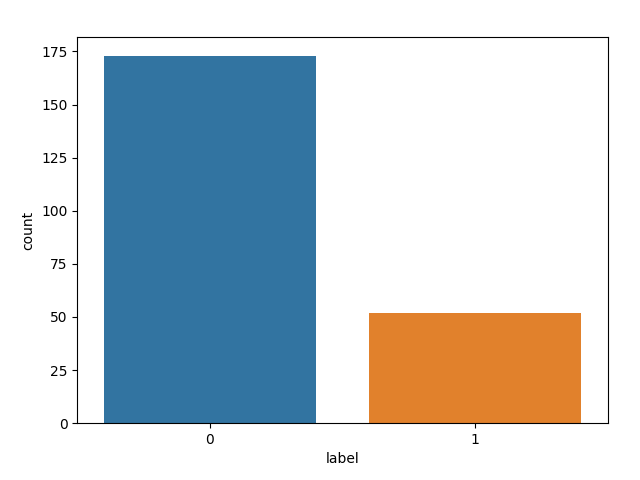

In [48]:
plt.clf()
sns.countplot(x='label', data=user_df.toPandas())
%matplot plt

In [49]:
user_df.groupBy(F.col('label')).count().show()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+-----+
|label|count|
+-----+-----+
|    1|   52|
|    0|  173|
+-----+-----+

In [50]:
feature_importance_lr.head(15)['variable']

VBox()

Exception in thread cell_monitor-49:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 16081



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1      membershipDurationDays
5               relThumbsDown
13             isPaidCustomer
2               numberOfSongs
3         numberOfSongsPerDay
9     numberOfSongsPerSession
12                 downgraded
6                 relThumbsUp
10               addedFriends
7             relSongsSkipped
8           relNumberOfErrors
11                       skew
0              isGenderFemale
4           downgradeAttempts
Name: variable, dtype: object

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

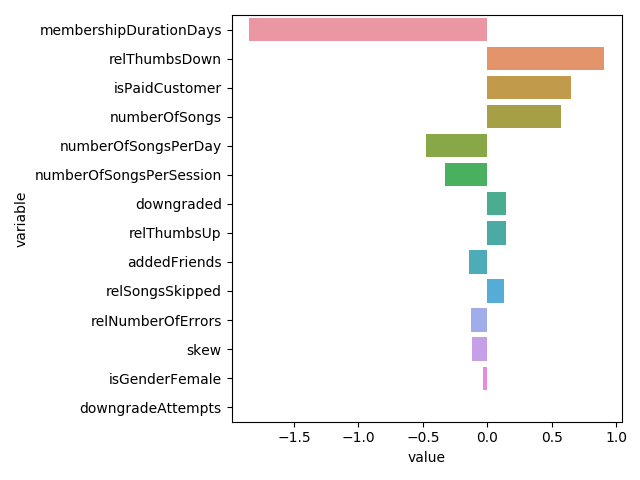

In [51]:
plt.clf()
sns.barplot(x='value', y='variable', data=feature_importance_lr)
plt.tight_layout()
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

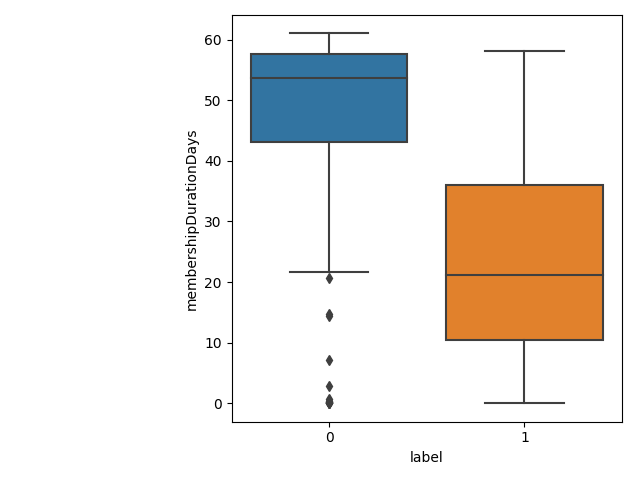

In [52]:
boxplot('membershipDurationDays', user_df)
%matplot plt

The boxplot shows a significant difference in the KPI for membershipDurationDays for churned and not churned customers. 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

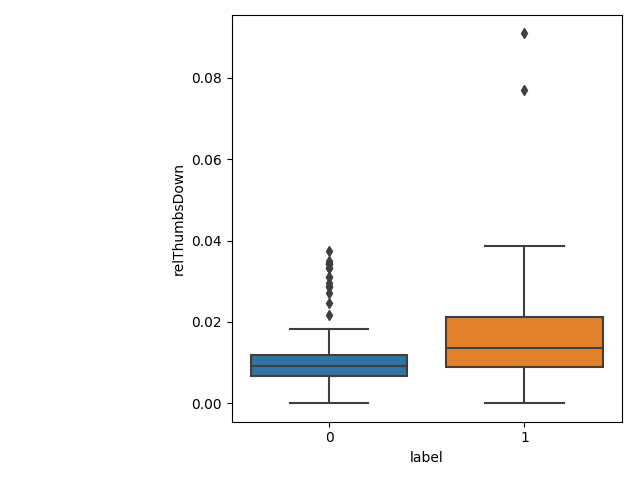

In [53]:
boxplot('relThumbsDown', user_df)
%matplot plt

The boxplot shows a significant difference in the KPI for relThumbsDown for churned and not churned customers. 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

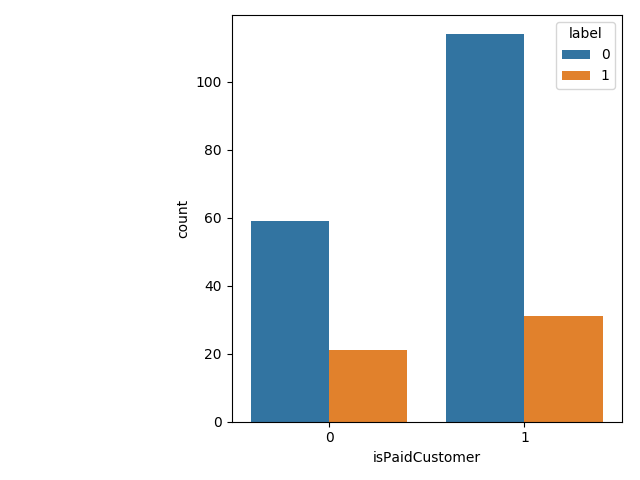

In [54]:
plt.clf()
sns.countplot(x='isPaidCustomer', hue='label', data=user_df.toPandas())
%matplot plt

The countplot shows a significant difference for paid customers and not paid customers for churned and not churned customers. 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

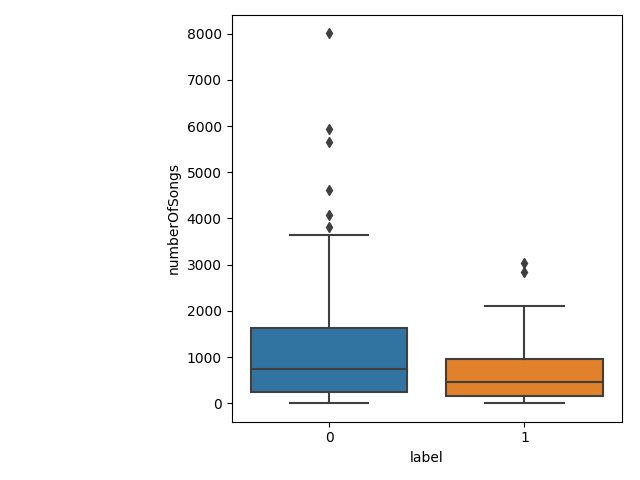

In [55]:
boxplot('numberOfSongs', user_df)
%matplot plt

The countplot shows a significant difference for the KPI numberOfSongs for churned and not churned customers. 

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

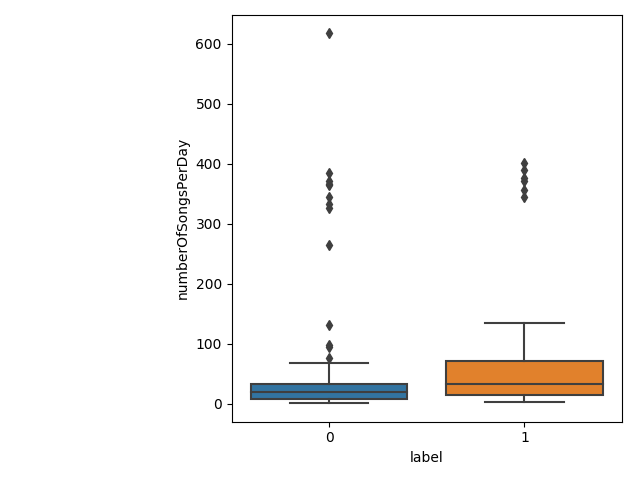

In [56]:
boxplot('numberOfSongsPerDay', user_df)
%matplot plt

The countplot shows a significant difference for the KPI numberOfSongsPerDay for churned and not churned customers. 

VBox()

Exception in thread cell_monitor-55:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/opt/conda/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.7/site-packages/awseditorssparkmonitoringwidget-1.0-py3.7.egg/awseditorssparkmonitoringwidget/cellmonitor.py", line 178, in cell_monitor
    job_binned_stages[job_id][stage_id] = all_stages[stage_id]
KeyError: 16182



FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

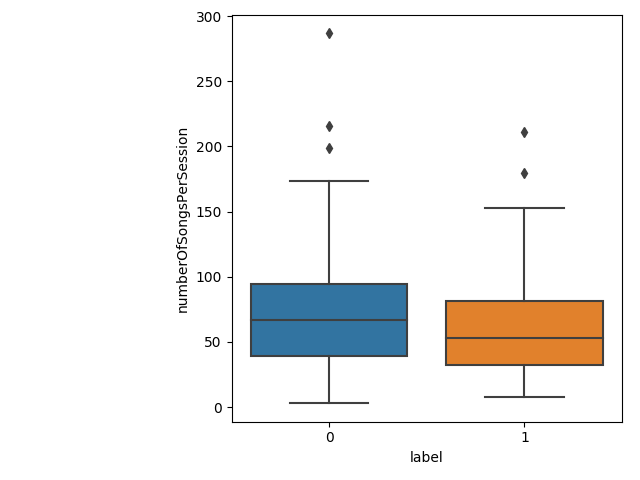

In [57]:
boxplot('numberOfSongsPerSession', user_df)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

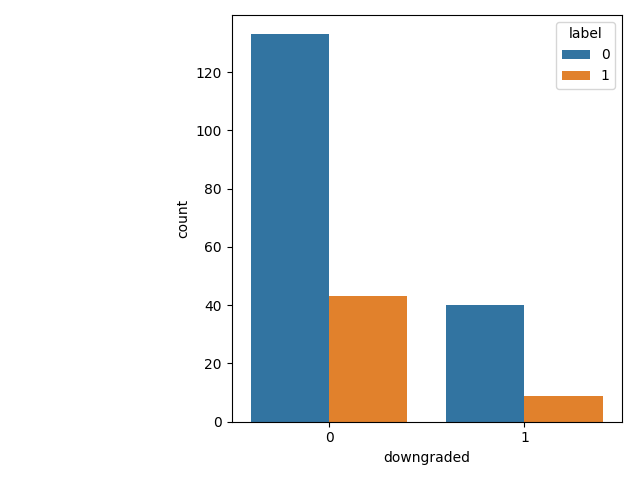

In [58]:
plt.clf()
sns.countplot(x='downgraded', hue='label', data=user_df.toPandas())
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

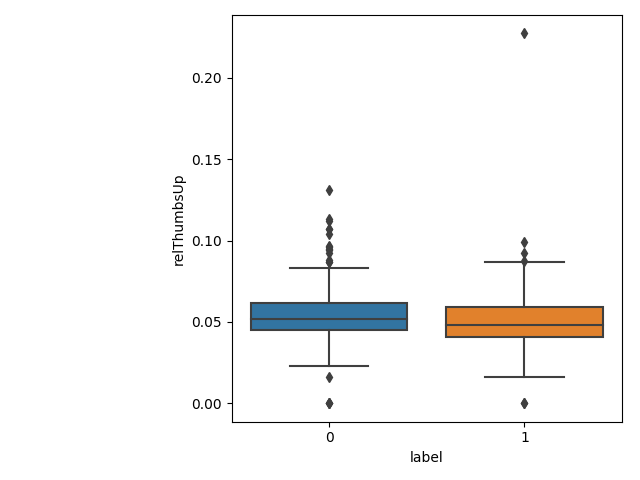

In [59]:
boxplot('relThumbsUp', user_df)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

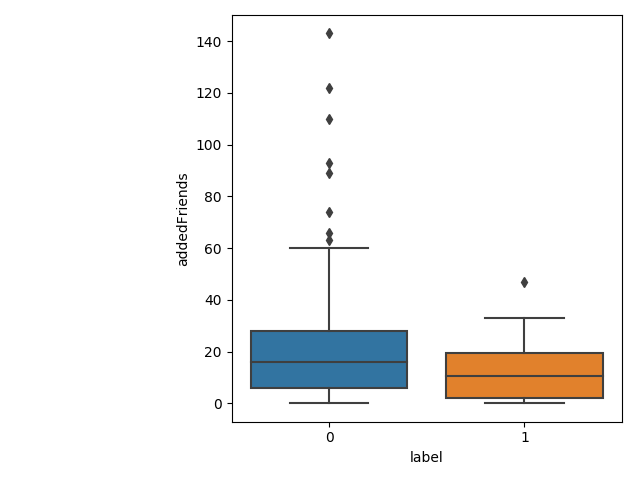

In [60]:
boxplot('addedFriends', user_df)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

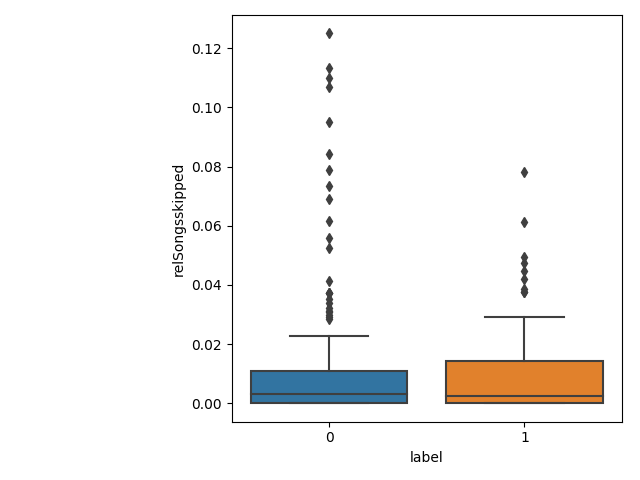

In [61]:
boxplot('relSongsskipped', user_df)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

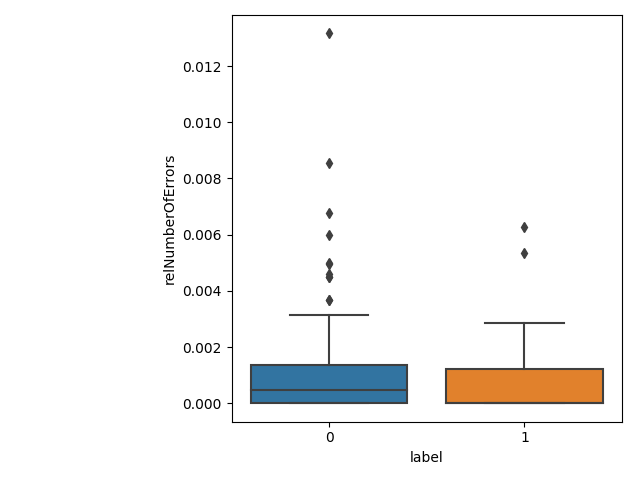

In [62]:
boxplot('relNumberOfErrors', user_df)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

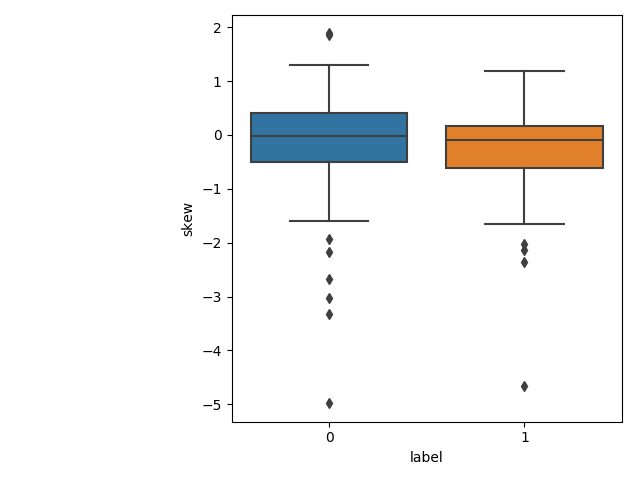

In [63]:
boxplot('skew', user_df)
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

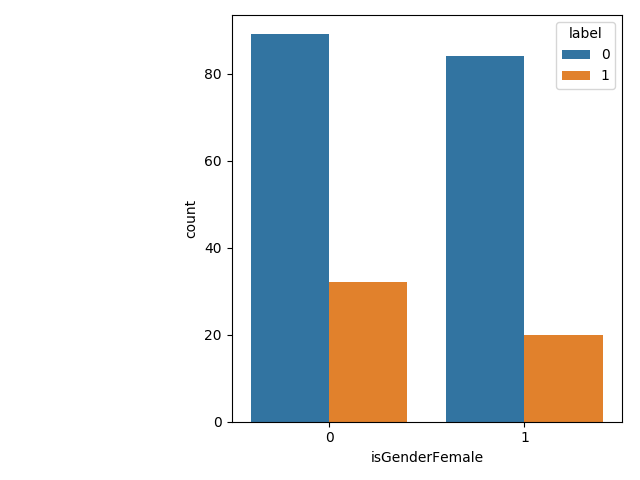

In [64]:
plt.clf()
sns.countplot(x='isGenderFemale', hue='label', data=user_df.toPandas())
%matplot plt

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

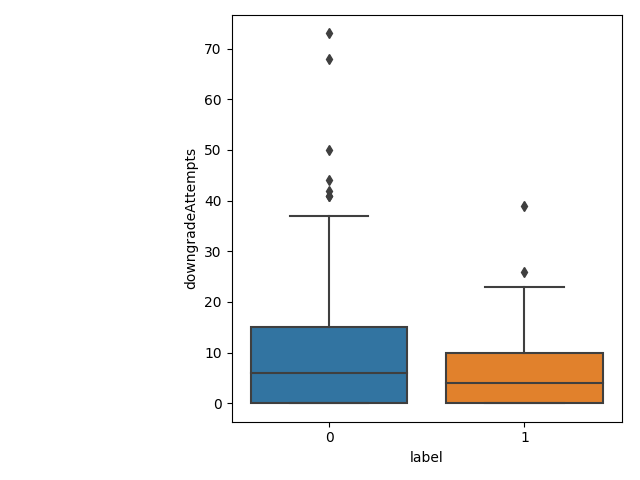

In [65]:
boxplot('downgradeAttempts', user_df)
%matplot plt

# Conclusion

We achieved our initial target to create a model capable to predict customer churn based on the Sparkify dataset with a Recall score greater than 80%. We even reached 88%. The key for this performance was the calculation of good measures.
To improve the model further we could try further parameter tuning on these models or even try out different models like Random Forests or XGBoost. Also, a couple of information in the dataset has not been used in thus project. For instance, the usage of the service on special daytimes, the location of the user or the browser/client the user is using might also keep some predictive power.